# Building Dataset

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import LabelEncoder

QQQ Holdings Data downloaded from [Invesco](https://www.invesco.com/us/financial-products/etfs/holdings?audienceType=Investor&ticker=QQQ)

In [ ]:
df_qqq_holdings = pd.read_csv("qqq_holdings.csv")
df_qqq_holdings.head()

In [ ]:
np.array(df_qqq_holdings['Holding Ticker'].str.strip())

Run SQL Queries on [Dolthub](https://www.dolthub.com/repositories/post-no-preference/earnings) based on the QQQ Tickers to Extract Earnings Data (saved in "earnings1.csv", "earnings2.csv") and Earnings Calendar (saved in "earnings_calendar1.csv", "earnings_calendar2.csv"). These data are split due to row limits in Dolthub.

In [ ]:
def get_earnings_df():
    df_earning_hist = pd.concat([
        pd.read_csv("earnings1.csv"),
        pd.read_csv("earnings2.csv")
    ], ignore_index=True)
    df_earning_hist['act_symbol'] = df_earning_hist['act_symbol'].astype(str)
    df_earning_hist['period_end_date'] = pd.to_datetime(df_earning_hist['period_end_date'])
    df_earning_hist['surprise'] = (df_earning_hist['reported'] - df_earning_hist['estimate'])
    df_earning_hist['surprise_pct'] = df_earning_hist['surprise']/df_earning_hist['estimate']
    df_earning_hist.rename(columns={'act_symbol': 'ticker'}, inplace=True)

    df_earning_hist.sort_values(['ticker', 'period_end_date'])
    df_earning_hist['avg_surprise_pct_4Q'] = df_earning_hist.groupby('ticker')['surprise_pct'].shift(1).rolling(4).mean().reset_index(0, drop=True)
    df_earning_hist['std_surprise_pct_4Q'] = df_earning_hist.groupby('ticker')['surprise_pct'].shift(1).rolling(4).std().reset_index(0, drop=True)
    df_earning_hist['pos_surprise_count_4Q'] = df_earning_hist.groupby('ticker')['surprise_pct'].shift(1).rolling(4).apply(lambda x: (x > 0).sum()).reset_index(0, drop=True)

    return df_earning_hist

df_earning_hist = get_earnings_df()
df_earning_hist.head()

,ticker,period_end_date,reported,estimate,surprise,surprise_pct,avg_surprise_pct_4Q,std_surprise_pct_4Q,pos_surprise_count_4Q
0,AAPL,2020-03-31,2.55,2.09,0.46,0.220096,NaN,NaN,NaN
1,AAPL,2020-06-30,2.58,2.03,0.55,0.270936,NaN,NaN,NaN
2,AAPL,2020-09-30,0.73,0.69,0.04,0.057971,NaN,NaN,NaN
3,AAPL,2020-12-31,1.68,1.41,0.27,0.191489,NaN,NaN,NaN
4,AAPL,2021-03-31,1.40,1.00,0.40,0.400000,0.185123,0.090912,4.0


In [ ]:
def get_earnings_calendar_df(print_head=False):
    df_earning_calendar = pd.concat([
        pd.read_csv("earnings_calendar1.csv"),
        pd.read_csv("earnings_calendar2.csv")
    ], ignore_index=True)
    df_earning_calendar['act_symbol'] = df_earning_calendar['act_symbol'].astype(str)
    df_earning_calendar['date'] = pd.to_datetime(df_earning_calendar['date'])
    df_earning_calendar['when'] = np.where(
        df_earning_calendar['when'] == 'After market close', 1,
        np.where(df_earning_calendar['when'] == 'Before market open', 0, np.nan)
    )
    df_earning_calendar.rename(columns={'act_symbol': 'ticker', 'date': 'earning_release_date', 'when': 'is_after_market'}, inplace=True)

    if print_head:
      print(df_earning_calendar.head())

    return df_earning_calendar

df_earning_calendar = get_earnings_calendar_df(print_head=True)

  ticker earning_release_date  is_after_market
0   AAPL           2020-01-28              1.0
1   AAPL           2020-04-30              1.0
2   AAPL           2020-07-30              1.0
3   AAPL           2020-10-29              1.0
4   AAPL           2021-01-27              1.0


In [ ]:
def merge_earnings_data(df_earning_calendar, df_earning_hist):
    df_earning_calendar = df_earning_calendar.sort_values('earning_release_date')
    df_earning_hist = df_earning_hist.sort_values('period_end_date')

    df_earning = pd.merge_asof(
        df_earning_hist,
        df_earning_calendar,
        left_on='period_end_date',
        right_on='earning_release_date',
        by='ticker',
        direction='forward'
    )

    df_earning['post_earning_release_date'] = df_earning.apply(
        lambda row: row['earning_release_date'] + pd.Timedelta(days=1)
        if row.get('is_after_market', True) else row['earning_release_date'],
        axis=1
    )
    df_earning['pre_earning_release_date'] = df_earning['post_earning_release_date'] + pd.Timedelta(days=-1)

    return df_earning

df_earning = merge_earnings_data(df_earning_calendar, df_earning_hist)

In [ ]:
df_earning.head()

,ticker,period_end_date,reported,estimate,surprise,surprise_pct,avg_surprise_pct_4Q,std_surprise_pct_4Q,pos_surprise_count_4Q,earning_release_date,is_after_market,post_earning_release_date,pre_earning_release_date
0,ROST,2020-01-31,1.28,1.26,0.02,0.015873,NaN,NaN,NaN,2020-03-03,1.0,2020-03-04,2020-03-03
1,MRVL,2020-01-31,0.17,0.16,0.01,0.062500,NaN,NaN,NaN,2020-03-04,1.0,2020-03-05,2020-03-04
2,SNPS,2020-01-31,1.01,0.92,0.09,0.097826,NaN,NaN,NaN,2020-02-19,1.0,2020-02-20,2020-02-19
3,AVGO,2020-01-31,5.25,5.22,0.03,0.005747,NaN,NaN,NaN,2020-03-12,1.0,2020-03-13,2020-03-12
4,CRWD,2020-01-31,-0.02,-0.08,0.06,-0.750000,NaN,NaN,NaN,2020-03-19,1.0,2020-03-20,2020-03-19


In [ ]:
df_earning.columns

Index(['ticker', 'period_end_date', 'reported', 'estimate', 'surprise',
       'surprise_pct', 'avg_surprise_pct_4Q', 'std_surprise_pct_4Q',
       'pos_surprise_count_4Q', 'earning_release_date', 'is_after_market',
       'post_earning_release_date', 'pre_earning_release_date'],
      dtype='object')

Get Stock Price Data around earning release dates from yfinance

In [ ]:
def get_price_features(symbol, df_earning):
    stock_data = yf.Ticker(symbol)
    historical_prices = stock_data.history(period="5y")

    if historical_prices.empty:
        return pd.DataFrame()

    historical_prices.index = pd.to_datetime(historical_prices.index.date)

    for days in range(1, 5):
        historical_prices[f'Close_prev_{days}D'] = historical_prices['Close'].shift(days)
        historical_prices[f'Volume_prev_{days}D'] = historical_prices['Volume'].shift(days)

    for window in [5, 30]:
        historical_prices[f'Rolling_{window}D_Avg'] = historical_prices['Close'].shift(1).rolling(window).mean()
        historical_prices[f'Rolling_{window}D_Std'] = historical_prices['Close'].shift(1).rolling(window).std()
        historical_prices[f'Rolling_{window}D_Volume'] = historical_prices['Volume'].shift(1).rolling(window).mean()
        historical_prices[f'Volatility_{window}D'] = historical_prices['Close'].shift(1).rolling(window).std() / historical_prices['Close'].shift(1).rolling(window).mean()

    historical_prices['Momentum_5D'] = historical_prices['Close'].shift(1) / historical_prices['Close'].shift(5) - 1
    historical_prices['MACD'] = (
        historical_prices['Close'].ewm(span=12, adjust=False).mean() -
        historical_prices['Close'].ewm(span=26, adjust=False).mean()
    ).shift(1)

    historical_prices['dayofweek'] = historical_prices.index.dayofweek
    historical_prices['month'] = historical_prices.index.month

    historical_prices = historical_prices.reset_index().rename(columns={'index': 'date'})
    historical_prices['ticker'] = symbol

    earnings_subset = df_earning[df_earning['ticker'] == symbol].copy()

    merged = pd.merge(
        earnings_subset,
        historical_prices,
        left_on='earning_release_date',
        right_on='date',
        how='left'
    )
    merged.drop(columns=['ticker_y'], inplace=True)
    merged.rename(columns={'ticker_x': 'ticker'}, inplace=True)

    return merged


In [ ]:
def get_macro_features(df_earning, ticker):
  ticker_df = yf.Ticker(ticker).history(period="5y")
  ticker_df.index = pd.to_datetime(ticker_df.index.date)

  for days in range(1, 5):
      ticker_df[f'Close_prev_{days}D'] = ticker_df['Close'].shift(days)
      ticker_df[f'Volume_prev_{days}D'] = ticker_df['Volume'].shift(days)

  rolling_windows = [5, 30]
  for window in rolling_windows:
      ticker_df[f'Rolling_{window}D_Avg'] = ticker_df['Close'].rolling(window).mean()
      ticker_df[f'Rolling_{window}D_Std'] = ticker_df['Close'].rolling(window).std()

  ticker_df[f'Momentum_5D'] = ticker_df['Close'].shift(1) / ticker_df['Close'].shift(5) - 1
  ticker_df[f'MACD'] = (
        ticker_df['Close'].ewm(span=12, adjust=False).mean() -
        ticker_df['Close'].ewm(span=26, adjust=False).mean()
    ).shift(1)

  ticker_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
  ticker_df = ticker_df.add_prefix(f'{ticker}_')
  ticker_df = ticker_df.reset_index()
  ticker_df = ticker_df.rename(columns={'index': 'date'})

  merged = pd.merge(
        df_earning,
        ticker_df,
        left_on='earning_release_date',
        right_on='date',
        how='left'
    )

  merged.drop(columns=['date_y'], inplace=True)
  merged.rename(columns={'date_x': 'date'}, inplace=True)

  return merged

In [ ]:
def build_model_df():
    df_earning_calendar = get_earnings_calendar_df()
    df_earning_hist = get_earnings_df()
    df_earning = merge_earnings_data(df_earning_calendar, df_earning_hist)
    all_dfs = []
    for symbol in df_earning['ticker'].unique():
        result = get_price_features(symbol, df_earning)
        if not result.empty:
            all_dfs.append(result)
    df = pd.concat(all_dfs, ignore_index=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['surprise_macd'] = df['surprise_pct'] * df['MACD']
    df['surprise_volatility'] = df['surprise_pct'] * df['Rolling_5D_Std']
    df['surprise_norm_std'] = df['surprise_pct'] / (df['Rolling_30D_Std'] + 1e-6)
    df['short_vs_long_volatility'] = df['Rolling_5D_Std'] / (df['Rolling_30D_Std'] + 1e-6)

    df = get_macro_features(df, 'QQQ')
    df = get_macro_features(df, '^VIX')
    df = get_macro_features(df, '^IRX')

    avg_close_pre2024 = df[df['date'] < '2024-01-01'].groupby('ticker')['Close'].mean().to_dict()
    df['ticker_avg_close_encoded'] = df['ticker'].map(avg_close_pre2024)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

df = build_model_df()

In [ ]:
df.head()

,ticker,period_end_date,reported,estimate,surprise,surprise_pct,avg_surprise_pct_4Q,std_surprise_pct_4Q,pos_surprise_count_4Q,earning_release_date,...,^IRX_Volume_prev_3D,^IRX_Close_prev_4D,^IRX_Volume_prev_4D,^IRX_Rolling_5D_Avg,^IRX_Rolling_5D_Std,^IRX_Rolling_30D_Avg,^IRX_Rolling_30D_Std,^IRX_Momentum_5D,^IRX_MACD,ticker_avg_close_encoded
0,ROST,2020-01-31,1.28,1.26,0.02,0.015873,NaN,NaN,NaN,2020-03-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.084068
1,ROST,2020-04-30,-0.29,-0.01,-0.28,28.000000,NaN,NaN,NaN,2020-05-21,...,0.0,0.103,0.0,0.1108,0.007050,NaN,NaN,0.123810,0.006016,103.084068
2,ROST,2020-07-31,-0.13,-0.31,0.18,-0.580645,NaN,NaN,NaN,2020-08-20,...,0.0,0.088,0.0,0.0912,0.006140,0.098467,0.013380,0.055556,-0.005494,103.084068
3,ROST,2020-10-31,1.02,0.63,0.39,0.619048,NaN,NaN,NaN,2020-11-19,...,0.0,0.083,0.0,0.0746,0.008849,0.086000,0.007566,-0.117647,-0.002665,103.084068
4,ROST,2021-01-31,0.67,1.03,-0.36,-0.349515,7.013569,13.999524,3.0,2021-03-02,...,0.0,0.028,0.0,0.0318,0.003564,0.042133,0.017758,0.217391,-0.008021,103.084068


In [ ]:
np.array(df.columns)

array(['ticker', 'period_end_date', 'reported', 'estimate', 'surprise',
       'surprise_pct', 'avg_surprise_pct_4Q', 'std_surprise_pct_4Q',
       'pos_surprise_count_4Q', 'earning_release_date', 'is_after_market',
       'post_earning_release_date', 'pre_earning_release_date', 'date',
       'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Close_prev_1D', 'Volume_prev_1D', 'Close_prev_2D',
       'Volume_prev_2D', 'Close_prev_3D', 'Volume_prev_3D',
       'Close_prev_4D', 'Volume_prev_4D', 'Rolling_5D_Avg',
       'Rolling_5D_Std', 'Rolling_5D_Volume', 'Volatility_5D',
       'Rolling_30D_Avg', 'Rolling_30D_Std', 'Rolling_30D_Volume',
       'Volatility_30D', 'Momentum_5D', 'MACD', 'dayofweek', 'month',
       'surprise_macd', 'surprise_volatility', 'surprise_norm_std',
       'short_vs_long_volatility', 'QQQ_Open', 'QQQ_High', 'QQQ_Low',
       'QQQ_Close', 'QQQ_Volume', 'QQQ_Capital Gains',
       'QQQ_Close_prev_1D', 'QQQ_Volume_prev_1D', 'QQQ_Close_p

# Causal Pathways

In [ ]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('aggregate_earnings.csv')

<ipython-input-6-cc5616541d36>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['vix_environment'] = pd.qcut(df_clean['^VIX_Close'], q=3, labels=['Low VIX', 'Medium VIX', 'High VIX'])
<ipython-input-6-cc5616541d36>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['vix_surprise_interaction'] = df_clean['^VIX_Close'] * df_clean['surprise_pct']
<ipython-input-6-cc5616541d36>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in


Market Volatility → Earnings Response Analysis:
Low VIX Earnings Response Coefficient: -0.1072, p-value: 0.2072
Medium VIX Earnings Response Coefficient: -0.2234, p-value: 0.0975
High VIX Earnings Response Coefficient: 0.0149, p-value: 0.8587
VIX-Surprise Interaction Coefficient: 0.0142, p-value: 0.3680

Earnings Surprise History → Current Earnings Response:
Poor History Response Coefficient: -0.1492, p-value: 0.2341
Below Average History Response Coefficient: 0.0383, p-value: 0.2369
Above Average History Response Coefficient: 0.0916, p-value: 0.6867
Excellent History Response Coefficient: 0.1109, p-value: 0.5078
History-Surprise Interaction Coefficient: 0.1093, p-value: 0.0590

Pre-Earnings Trading Volume → Earnings Response:
Low Volume Response Coefficient: -0.0523, p-value: 0.6014
Normal Volume Response Coefficient: -0.2531, p-value: 0.1304
High Volume Response Coefficient: 0.0711, p-value: 0.5065
Volume-Surprise Interaction Coefficient: 0.0613, p-value: 0.7039


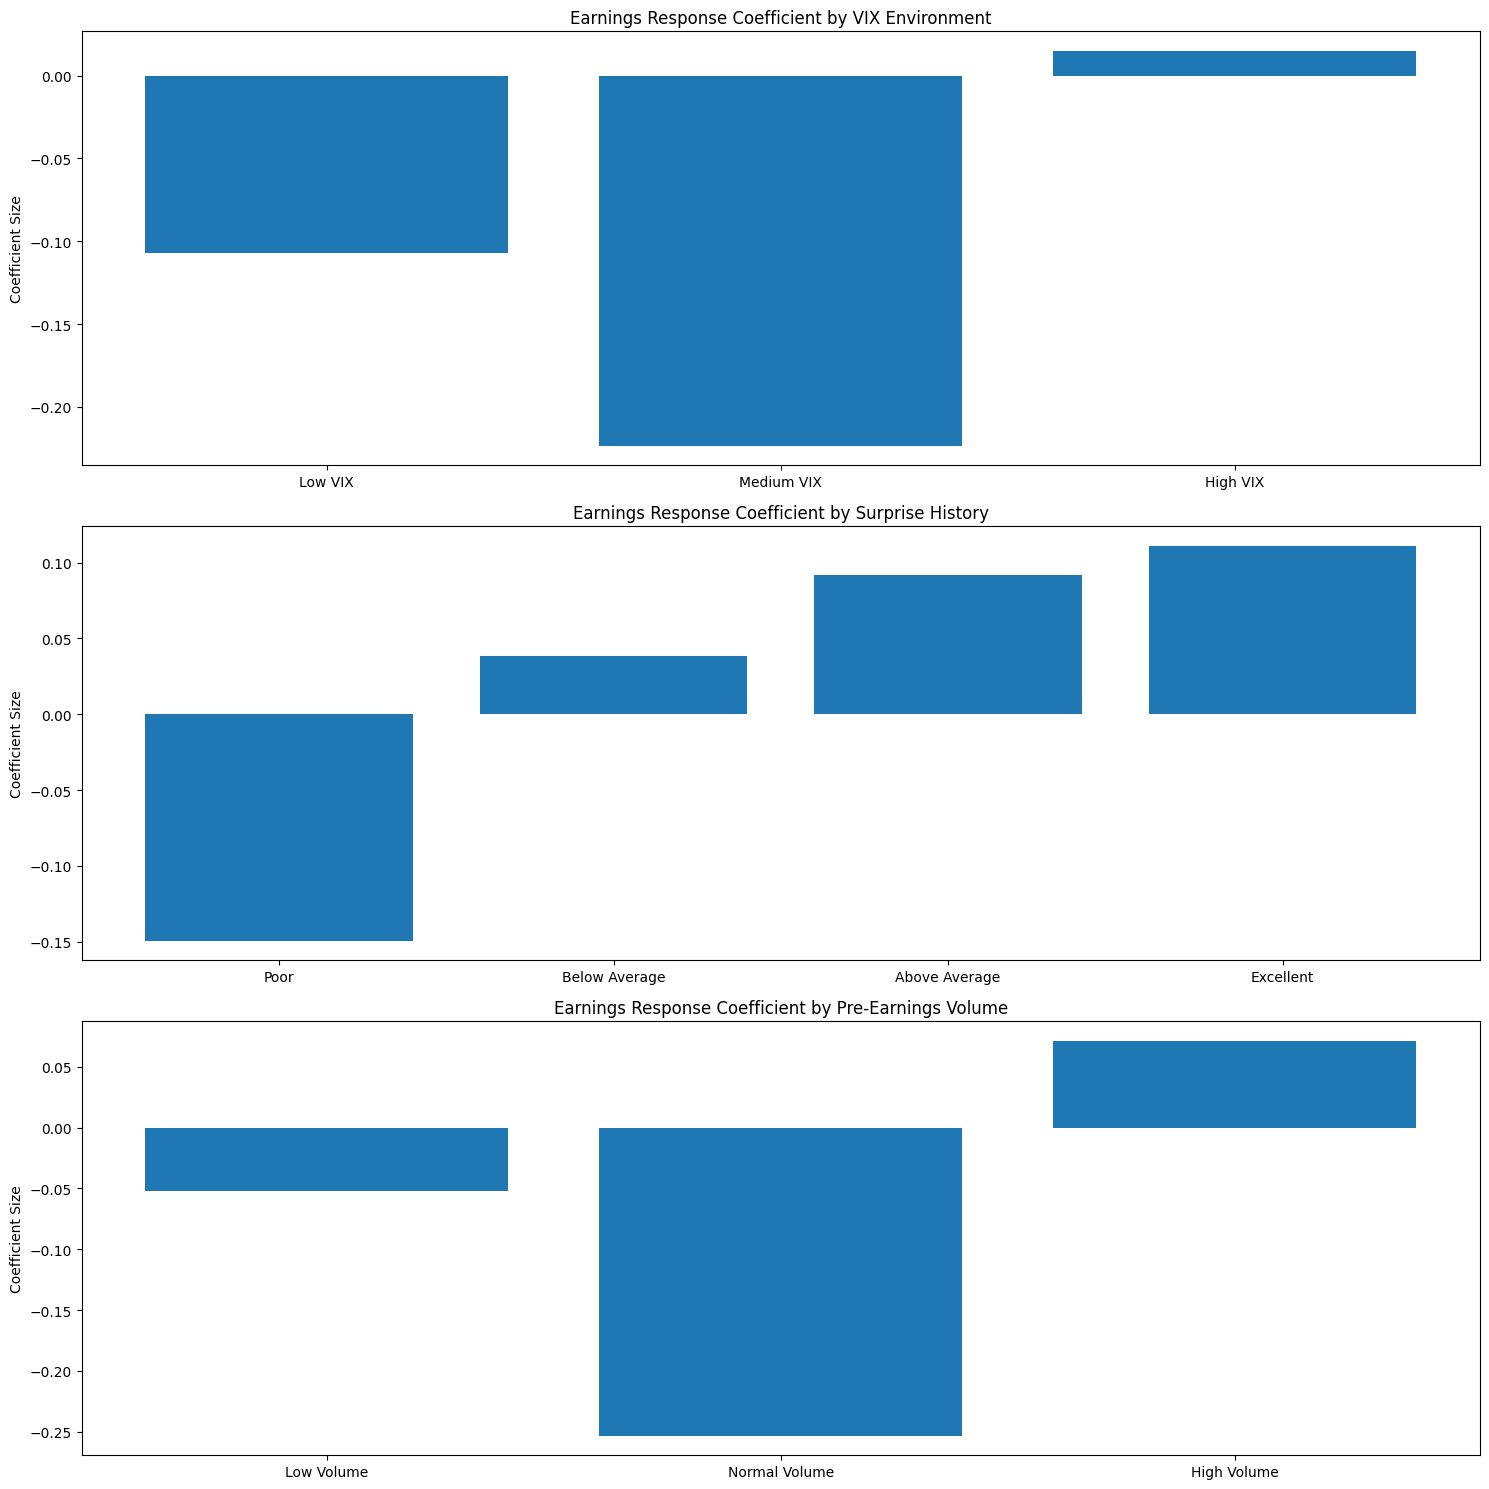

In [ ]:
df['price_reaction'] = (df['Close'] - df['Close_prev_1D']) / df['Close_prev_1D'] * 100
df.replace([np.inf, -np.inf], np.nan, inplace=True)

controls = ['QQQ_Close_prev_1D', 'ticker_avg_close_encoded', 'Rolling_30D_Avg', 'month', 'dayofweek']

key_vars = ['price_reaction', 'surprise_pct', '^VIX_Close', 'pos_surprise_count_4Q', 'std_surprise_pct_4Q'] + controls
df_clean = df.dropna(subset=key_vars)

try:
    df_clean['vix_environment'] = pd.qcut(df_clean['^VIX_Close'], q=3, labels=['Low VIX', 'Medium VIX', 'High VIX'])
except:
    vix_bins = [df_clean['^VIX_Close'].min(),
                df_clean['^VIX_Close'].quantile(0.33),
                df_clean['^VIX_Close'].quantile(0.67),
                df_clean['^VIX_Close'].max()]
    df_clean['vix_environment'] = pd.cut(df_clean['^VIX_Close'], bins=vix_bins, labels=['Low VIX', 'Medium VIX', 'High VIX'])

results_by_vix = {}
for vix_env in ['Low VIX', 'Medium VIX', 'High VIX']:
    vix_data = df_clean[df_clean['vix_environment'] == vix_env]
    if len(vix_data) > 10:
        X = sm.add_constant(vix_data[['surprise_pct'] + controls])
        model = sm.OLS(vix_data['price_reaction'], X).fit(cov_type='HC3')
        results_by_vix[vix_env] = model

df_clean['vix_surprise_interaction'] = df_clean['^VIX_Close'] * df_clean['surprise_pct']
X_full = sm.add_constant(df_clean[['surprise_pct', '^VIX_Close', 'vix_surprise_interaction'] + controls])
full_model = sm.OLS(df_clean['price_reaction'], X_full).fit(cov_type='HC3')

print("\nMarket Volatility → Earnings Response Analysis:")
for env, model in results_by_vix.items():
    print(f"{env} Earnings Response Coefficient: {model.params['surprise_pct']:.4f}, p-value: {model.pvalues['surprise_pct']:.4f}")
print(f"VIX-Surprise Interaction Coefficient: {full_model.params['vix_surprise_interaction']:.4f}, p-value: {full_model.pvalues['vix_surprise_interaction']:.4f}")


try:
    df_clean['surprise_history'] = pd.qcut(df_clean['pos_surprise_count_4Q'], q=4, labels=['Poor', 'Below Average', 'Above Average', 'Excellent'])
except:
    bins = [df_clean['pos_surprise_count_4Q'].min()-0.001, 1, 2, 3, df_clean['pos_surprise_count_4Q'].max()+0.001]
    df_clean['surprise_history'] = pd.cut(df_clean['pos_surprise_count_4Q'], bins=bins, labels=['Poor', 'Below Average', 'Above Average', 'Excellent'])

try:
    df_clean['surprise_consistency'] = pd.qcut(df_clean['std_surprise_pct_4Q'], q=3, labels=['Consistent', 'Average', 'Inconsistent'])
except:
    std_bins = [df_clean['std_surprise_pct_4Q'].min(),
                df_clean['std_surprise_pct_4Q'].quantile(0.33),
                df_clean['std_surprise_pct_4Q'].quantile(0.67),
                df_clean['std_surprise_pct_4Q'].max()]
    df_clean['surprise_consistency'] = pd.cut(df_clean['std_surprise_pct_4Q'], bins=std_bins, labels=['Consistent', 'Average', 'Inconsistent'])

results_by_history = {}
for history in ['Poor', 'Below Average', 'Above Average', 'Excellent']:
    history_data = df_clean[df_clean['surprise_history'] == history]
    if len(history_data) > 10:
        X = sm.add_constant(history_data[['surprise_pct'] + controls])
        model = sm.OLS(history_data['price_reaction'], X).fit(cov_type='HC3')
        results_by_history[history] = model

df_clean['surprise_history_num'] = df_clean['pos_surprise_count_4Q']
df_clean['history_surprise_interaction'] = df_clean['surprise_history_num'] * df_clean['surprise_pct']
X_history = sm.add_constant(df_clean[['surprise_pct', 'surprise_history_num', 'history_surprise_interaction'] + controls])
history_model = sm.OLS(df_clean['price_reaction'], X_history).fit(cov_type='HC3')

print("\nEarnings Surprise History → Current Earnings Response:")
for history, model in results_by_history.items():
    print(f"{history} History Response Coefficient: {model.params['surprise_pct']:.4f}, p-value: {model.pvalues['surprise_pct']:.4f}")
print(f"History-Surprise Interaction Coefficient: {history_model.params['history_surprise_interaction']:.4f}, p-value: {history_model.pvalues['history_surprise_interaction']:.4f}")


if 'Volume_prev_1D' in df_clean.columns and 'Rolling_30D_Volume' in df_clean.columns:
    df_clean['pre_earnings_abnormal_volume'] = df_clean['Volume_prev_1D'] / df_clean['Rolling_30D_Volume']

    df_clean = df_clean.dropna(subset=['pre_earnings_abnormal_volume'])

    try:
        df_clean['volume_pattern'] = pd.qcut(df_clean['pre_earnings_abnormal_volume'], q=3,
                                         labels=['Low Volume', 'Normal Volume', 'High Volume'])
    except:
        vol_bins = [df_clean['pre_earnings_abnormal_volume'].min(),
                    df_clean['pre_earnings_abnormal_volume'].quantile(0.33),
                    df_clean['pre_earnings_abnormal_volume'].quantile(0.67),
                    df_clean['pre_earnings_abnormal_volume'].max()]
        df_clean['volume_pattern'] = pd.cut(df_clean['pre_earnings_abnormal_volume'], bins=vol_bins,
                                       labels=['Low Volume', 'Normal Volume', 'High Volume'])

    volume_cols = ['Volume_prev_1D', 'Volume_prev_2D', 'Volume_prev_3D']
    if all(col in df_clean.columns for col in volume_cols):
        df_clean = df_clean.dropna(subset=volume_cols)
        df_clean['volume_trend'] = np.where(
            (df_clean['Volume_prev_1D'] > df_clean['Volume_prev_2D']) & (df_clean['Volume_prev_2D'] > df_clean['Volume_prev_3D']),
            'Rising',
            np.where(
                (df_clean['Volume_prev_1D'] < df_clean['Volume_prev_2D']) & (df_clean['Volume_prev_2D'] < df_clean['Volume_prev_3D']),
                'Falling',
                'Mixed'
            )
        )

        results_by_volume = {}
        for pattern in ['Low Volume', 'Normal Volume', 'High Volume']:
            pattern_data = df_clean[df_clean['volume_pattern'] == pattern]
            if len(pattern_data) > 10:
                X = sm.add_constant(pattern_data[['surprise_pct'] + controls])
                model = sm.OLS(pattern_data['price_reaction'], X).fit(cov_type='HC3')
                results_by_volume[pattern] = model

        results_by_trend = {}
        for trend in ['Rising', 'Falling', 'Mixed']:
            trend_data = df_clean[df_clean['volume_trend'] == trend]
            if len(trend_data) > 10:
                X = sm.add_constant(trend_data[['surprise_pct'] + controls])
                model = sm.OLS(trend_data['price_reaction'], X).fit(cov_type='HC3')
                results_by_trend[trend] = model

        df_clean['volume_surprise_interaction'] = df_clean['pre_earnings_abnormal_volume'] * df_clean['surprise_pct']
        X_volume = sm.add_constant(df_clean[['surprise_pct', 'pre_earnings_abnormal_volume', 'volume_surprise_interaction'] + controls])
        volume_model = sm.OLS(df_clean['price_reaction'], X_volume).fit(cov_type='HC3')

        print("\nPre-Earnings Trading Volume → Earnings Response:")
        for pattern, model in results_by_volume.items():
            print(f"{pattern} Response Coefficient: {model.params['surprise_pct']:.4f}, p-value: {model.pvalues['surprise_pct']:.4f}")
        print(f"Volume-Surprise Interaction Coefficient: {volume_model.params['volume_surprise_interaction']:.4f}, p-value: {volume_model.pvalues['volume_surprise_interaction']:.4f}")

        plt.figure(figsize=(15, 15))

        plt.subplot(3, 1, 1)
        vix_coeffs = [results_by_vix[env].params['surprise_pct'] for env in results_by_vix.keys()]
        plt.bar(list(results_by_vix.keys()), vix_coeffs)
        plt.title('Earnings Response Coefficient by VIX Environment')
        plt.ylabel('Coefficient Size')

        plt.subplot(3, 1, 2)
        history_coeffs = [results_by_history[h].params['surprise_pct'] for h in results_by_history.keys()]
        plt.bar(list(results_by_history.keys()), history_coeffs)
        plt.title('Earnings Response Coefficient by Surprise History')
        plt.ylabel('Coefficient Size')

        plt.subplot(3, 1, 3)
        volume_coeffs = [results_by_volume[p].params['surprise_pct'] for p in results_by_volume.keys()]
        plt.bar(list(results_by_volume.keys()), volume_coeffs)
        plt.title('Earnings Response Coefficient by Pre-Earnings Volume')
        plt.ylabel('Coefficient Size')

        plt.tight_layout()
        plt.savefig('earnings_response_analysis.png')

# Modeling

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
def data_setup(df):
    technical_features = [
    'Close_prev_1D',
       'Volume_prev_1D', 'Close_prev_2D', 'Volume_prev_2D', 'Close_prev_3D',
       'Volume_prev_3D', 'Close_prev_4D', 'Volume_prev_4D', 'Rolling_5D_Avg',
       'Rolling_5D_Std', 'Rolling_5D_Volume', 'Volatility_5D',
       'Rolling_30D_Avg', 'Rolling_30D_Std', 'Rolling_30D_Volume',
       'Volatility_30D', 'Momentum_5D', 'MACD', 'short_vs_long_volatility', 'ticker_avg_close_encoded'
    ]
    earnings_features = ['surprise_pct', 'avg_surprise_pct_4Q', 'std_surprise_pct_4Q',
          'pos_surprise_count_4Q', 'surprise_macd', 'surprise_volatility', 'surprise_norm_std']
    feature_cols_all = technical_features + earnings_features
    target_col = 'Close'

    df = df.dropna(subset=['Close'])
    df = df.dropna(subset=technical_features + earnings_features)

    df_train = df[df['date'] < pd.to_datetime("2024-01-01")]
    df_test = df[df['date'] >= pd.to_datetime("2024-01-01")]

    X_train_all = df_train[technical_features + earnings_features]
    X_train_no_earnings = df_train[technical_features]
    y_train = df_train['Close']

    X_test_all = df_test[technical_features + earnings_features]
    X_test_no_earnings = df_test[technical_features]
    y_test = df_test['Close']

    return df_train, df_test, X_train_all, X_train_no_earnings, y_train, X_test_all, X_test_no_earnings, y_test

In [ ]:
def run_models(df, is_train=True):
    df_train, df_test, X_train_all, X_train_no_earnings, y_train, X_test_all, X_test_no_earnings, y_test = data_setup(df)

    if is_train:
      model_all = LinearRegression().fit(X_train_all, y_train)
      model_no_earnings = LinearRegression().fit(X_train_no_earnings, y_train)

    df_train = df_train.copy()
    df_train['y_pred_all'] = model_all.predict(X_train_all)
    df_train['y_pred_no_earnings'] = model_no_earnings.predict(X_train_no_earnings)

    df_test = df_test.copy()
    df_test['y_pred_all'] = model_all.predict(X_test_all)
    df_test['y_pred_no_earnings'] = model_no_earnings.predict(X_test_no_earnings)

    return df_test, df_train

In [ ]:
df_train, df_test = run_models(df)

In [ ]:
print(f"Train (All Features):      {mean_squared_error(df_train['Close'], df_train['y_pred_all']):.2f}")
print(f"Train (No Earnings):       {mean_squared_error(df_train['Close'], df_train['y_pred_no_earnings']):.2f}")
print(f"Test  (All Features):      {mean_squared_error(df_test['Close'], df_test['y_pred_all']):.2f}")
print(f"Test  (No Earnings):       {mean_squared_error(df_test['Close'], df_test['y_pred_no_earnings']):.2f}")

Train (All Features):      324.37
Train (No Earnings):       332.57
Test  (All Features):      89.39
Test  (No Earnings):       92.19


In [ ]:
ticker_mse = []

for ticker, group in df_test.groupby('ticker'):
    mse_all = mean_squared_error(group['Close'], group['y_pred_all'])
    mse_no_earn = mean_squared_error(group['Close'], group['y_pred_no_earnings'])
    ticker_mse.append((ticker, mse_all, mse_no_earn))

mse_df = pd.DataFrame(ticker_mse, columns=['ticker', 'MSE_All', 'MSE_No_Earnings'])
mse_df['MSE_Diff'] = mse_df['MSE_No_Earnings'] - mse_df['MSE_All']
# mse_df = mse_df.sort_values('MSE_All')
mse_df = mse_df.sort_values('MSE_Diff', ascending=False)
good_mse_df = mse_df[mse_df['MSE_All'] < 10]

In [ ]:
select_mse_df = good_mse_df[good_mse_df['ticker'].isin(['TTWO', 'AZN', 'EXC'])]
select_mse_df

,ticker,MSE_All,MSE_No_Earnings,MSE_Diff
16,AZN,5.262988,4.794084,-0.468904
90,TTWO,9.323551,8.658456,-0.665095
37,EXC,5.178366,0.937934,-4.240432


MSE for AZN (All Features): 5.2630
MSE for AZN (No Earnings): 4.7941


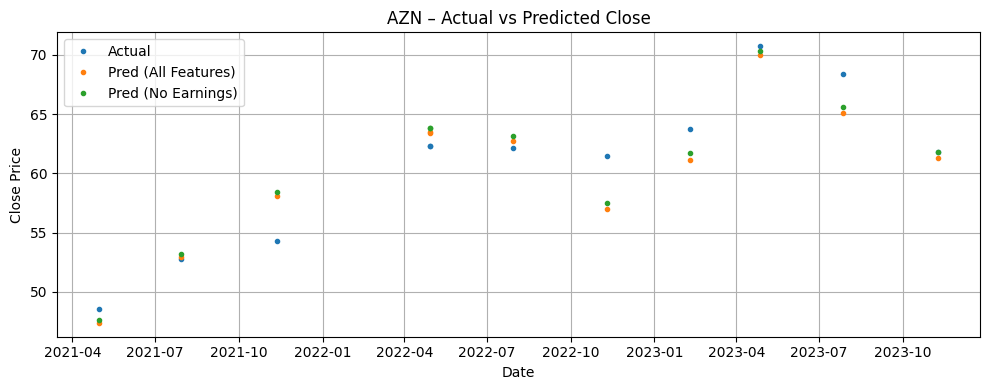

MSE for TTWO (All Features): 9.3236
MSE for TTWO (No Earnings): 8.6585


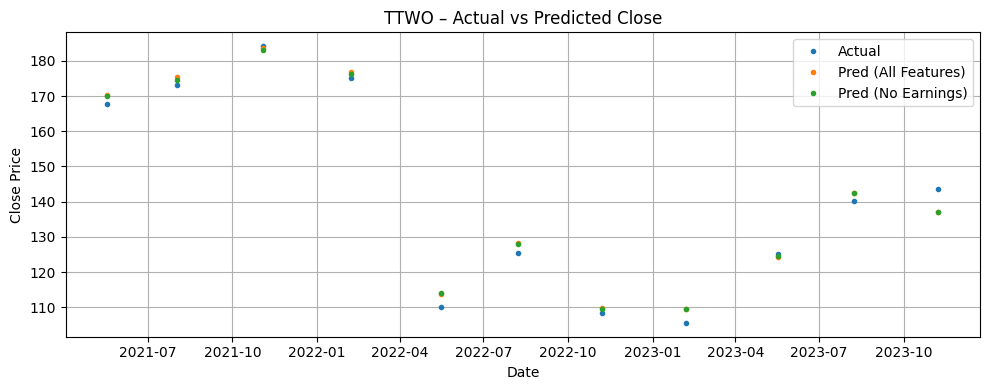

MSE for EXC (All Features): 5.1784
MSE for EXC (No Earnings): 0.9379


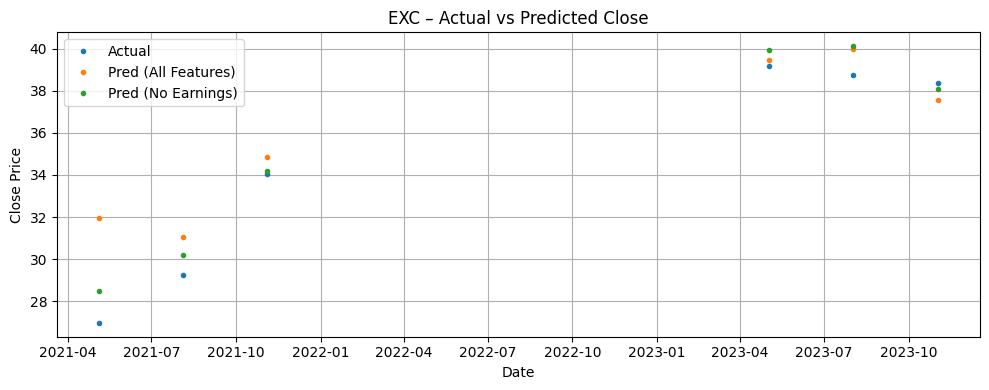

In [ ]:
sample_tickers = select_mse_df['ticker'].head(3).tolist()

for ticker in sample_tickers:
    group = df_test[df_test['ticker'] == ticker]
    # Calculate MSE for All Features and No Earnings as well
    mse_all = mean_squared_error(group['Close'], group['y_pred_all'])
    mse_no_earnings = mean_squared_error(group['Close'], group['y_pred_no_earnings'])
    print(f'MSE for {ticker} (All Features): {mse_all:.4f}')
    print(f'MSE for {ticker} (No Earnings): {mse_no_earnings:.4f}')

    plt.figure(figsize=(10, 4))
    plt.plot(group['date'], group['Close'], '.', label='Actual')
    plt.plot(group['date'], group['y_pred_all'], '.', label='Pred (All Features)')
    plt.plot(group['date'], group['y_pred_no_earnings'], '.', label='Pred (No Earnings)')
    plt.title(f'{ticker} – Actual vs Predicted Close')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def run_models(df, is_train=True):
    df_train, df_test, X_train_all, X_train_no_earnings, y_train, X_test_all, X_test_no_earnings, y_test = data_setup(df)

    if is_train:
      model_all = XGBRegressor(n_estimators=200, max_depth=5, random_state=42)
      model_no_earnings = XGBRegressor(n_estimators=200, max_depth=5, random_state=42)
      model_all.fit(X_train_all, y_train)
      model_no_earnings.fit(X_train_no_earnings, y_train)

    df_train = df_train.copy()
    df_train['y_pred_all'] = model_all.predict(X_train_all)
    df_train['y_pred_no_earnings'] = model_no_earnings.predict(X_train_no_earnings)

    df_test = df_test.copy()
    df_test['y_pred_all'] = model_all.predict(X_test_all)
    df_test['y_pred_no_earnings'] = model_no_earnings.predict(X_test_no_earnings)

    return df_test, df_train

df_test, df_train = run_models(df)

In [ ]:
print(f"Train (All Features):      {mean_squared_error(df_train['Close'], df_train['y_pred_all']):.2f}")
print(f"Train (No Earnings):       {mean_squared_error(df_train['Close'], df_train['y_pred_no_earnings']):.2f}")
print(f"Test  (All Features):      {mean_squared_error(df_test['Close'], df_test['y_pred_all']):.2f}")
print(f"Test  (No Earnings):       {mean_squared_error(df_test['Close'], df_test['y_pred_no_earnings']):.2f}")

ticker_mse = []

for ticker, group in df_test.groupby('ticker'):
    mse_all = mean_squared_error(group['Close'], group['y_pred_all'])
    mse_no_earn = mean_squared_error(group['Close'], group['y_pred_no_earnings'])
    ticker_mse.append((ticker, mse_all, mse_no_earn))

mse_df = pd.DataFrame(ticker_mse, columns=['ticker', 'MSE_All', 'MSE_No_Earnings'])
mse_df['MSE_Diff'] = mse_df['MSE_No_Earnings'] - mse_df['MSE_All']
mse_df = mse_df.sort_values('MSE_Diff', ascending=False)
good_mse_df = mse_df[mse_df['MSE_All'] < 10]

Train (All Features):      0.00
Train (No Earnings):       0.01
Test  (All Features):      24945.03
Test  (No Earnings):       22998.80


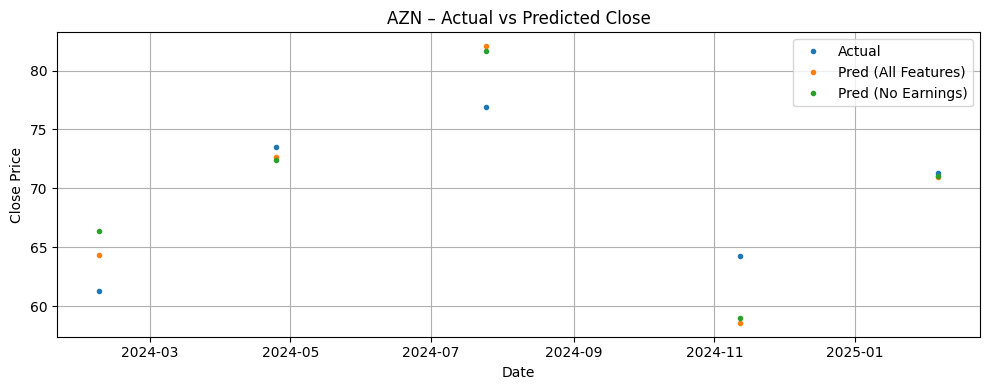

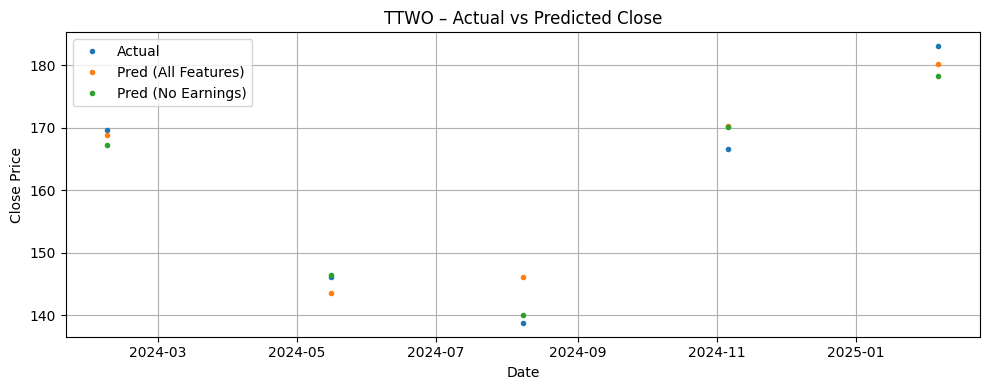

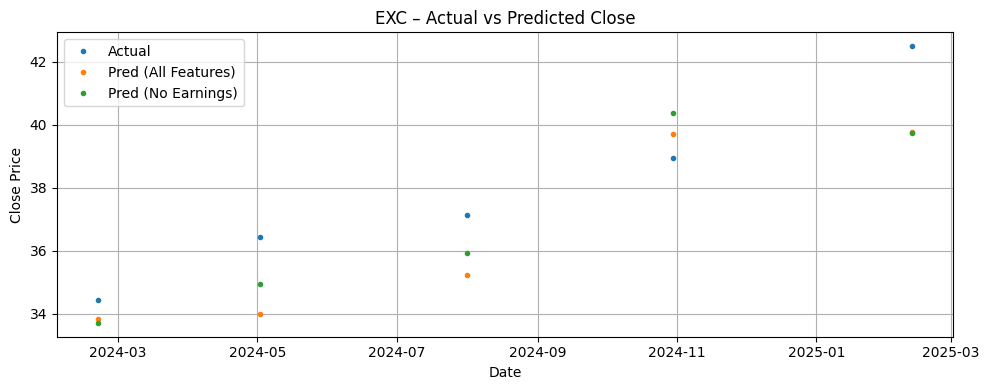

In [ ]:
sample_tickers = select_mse_df['ticker'].head(3).tolist()

for ticker in sample_tickers:
    group = df_test[df_test['ticker'] == ticker]
    plt.figure(figsize=(10, 4))
    plt.plot(group['date'], group['Close'], '.', label='Actual')
    plt.plot(group['date'], group['y_pred_all'], '.', label='Pred (All Features)')
    plt.plot(group['date'], group['y_pred_no_earnings'], '.', label='Pred (No Earnings)')
    plt.title(f'{ticker} – Actual vs Predicted Close')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install dowhy causalinference

In [ ]:
!pip install pgmpy

In [ ]:
import networkx as nx
import dowhy
import causalinference
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from pgmpy.estimators import PC, HillClimbSearch
from pgmpy.estimators.CITests import chi_square, pearsonr as pgmpy_pearsonr

def create_statistical_causal_graph(df, target_col='Close_next_1D', alpha=0.05, max_lag=5):
    df_numeric = df.select_dtypes(include=[np.number]).copy()
    df_numeric = df_numeric.fillna(df_numeric.mean())

    G = nx.DiGraph()

    features = [col for col in df_numeric.columns if col != target_col]
    G.add_nodes_from(features + [target_col])

    granger_edges = []

    for feature in features:
        granger_data = pd.concat([df_numeric[feature], df_numeric[target_col]], axis=1)
        try:
            gc_results = grangercausalitytests(granger_data, maxlag=max_lag, verbose=False)

            for lag in range(1, max_lag + 1):
                p_value = gc_results[lag][0]['ssr_ftest'][1]
                if p_value < alpha:
                    granger_edges.append((feature, target_col))
                    break
        except:
            print(f"  Warning: Granger test failed for {feature}")

    G.add_edges_from(granger_edges)

    correlation_edges = []

    for feature in features:
        try:
            corr, p_value = pearsonr(df_numeric[feature], df_numeric[target_col])

            if abs(corr) > 0.3 and p_value < alpha:
                if any(time_word in feature.lower() for time_word in ['prev', 'lag', 'past', 'rolling', 'avg', 'std']):
                    correlation_edges.append((feature, target_col))
        except:
            print(f"  Warning: Correlation test failed for {feature}")

    G.add_edges_from(correlation_edges)

    try:
        if len(features) > 15:
            correlations = []
            for feature in features:
                try:
                    corr, _ = pearsonr(df_numeric[feature], df_numeric[target_col])
                    correlations.append((feature, abs(corr)))
                except:
                    correlations.append((feature, 0))

            selected_features = [f[0] for f in sorted(correlations, key=lambda x: x[1], reverse=True)[:15]]
        else:
            selected_features = features

        subset_df = df_numeric[selected_features + [target_col]]

        scaler = StandardScaler()
        subset_scaled = pd.DataFrame(scaler.fit_transform(subset_df), columns=subset_df.columns)

        try:
            pc = PC(data=subset_scaled)
            pc_skeleton = pc.estimate(variant="stable", ci_test=pgmpy_pearsonr, return_type="skeleton", significance_level=alpha)

            pc_edges = []
            for edge in pc_skeleton.edges():
                if target_col in edge:
                    if edge[0] == target_col:
                        pc_edges.append((edge[1], edge[0]))
                    else:
                        pc_edges.append(edge)

            G.add_edges_from(pc_edges)
        except Exception as e:
            print(f"  PC algorithm failed: {e}")

            try:
                hc = HillClimbSearch(subset_scaled)
                hc_model = hc.estimate()

                hc_edges = []
                for edge in hc_model.edges():
                    if target_col in edge:
                        if edge[0] == target_col:
                            hc_edges.append((edge[1], edge[0]))
                        else:
                            hc_edges.append(edge)

                G.add_edges_from(hc_edges)
            except Exception as e:
                print(f"  Hill Climbing algorithm failed: {e}")
    except Exception as e:
        print(f"  Constraint-based discovery failed: {e}")


    direct_causes = list(G.predecessors(target_col))
    print(f"  Direct causes of {target_col}: {direct_causes}")

    indirect_causes = []
    for feature in features:
        if feature not in direct_causes and nx.has_path(G, feature, target_col):
            indirect_causes.append(feature)
    print(f"  Indirect causes of {target_col}: {indirect_causes}")

    try:
        centrality = nx.betweenness_centrality(G)
        sorted_centrality = sorted([(node, score) for node, score in centrality.items()
                                   if node != target_col],
                                  key=lambda x: x[1], reverse=True)
        central_nodes = [node[0] for node in sorted_centrality[:min(5, len(sorted_centrality))]]
    except:
        central_nodes = []
        print("  Warning: Centrality calculation failed")

    important_features = list(set(direct_causes + indirect_causes + central_nodes))

    if len(important_features) < 5 and len(features) > 10:
        X = df_numeric[features]
        y = df_numeric[target_col]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        lasso = LassoCV(cv=5, random_state=42)
        lasso.fit(X_scaled, y)

        lasso_features = [features[i] for i in range(len(features)) if abs(lasso.coef_[i]) > 0]

        important_features = list(set(important_features + lasso_features))

    print(f"Final list of important features: {important_features}")

    return G, important_features

def visualize_causal_graph(G, important_features, title="Statistical Causal Graph"):
    plt.figure(figsize=(12, 10))

    pos = nx.spring_layout(G, k=0.5, seed=42)

    regular_nodes = [node for node in G.nodes() if node not in important_features]
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes,
                         node_color='lightblue', node_size=1000, alpha=0.7)

    nx.draw_networkx_nodes(G, pos, nodelist=important_features,
                         node_color='red', node_size=1500, alpha=0.9)

    target_nodes = [node for node in G.nodes() if 'next' in node.lower()]
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes,
                         node_color='green', node_size=2000, alpha=0.9)

    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15,
                         edge_color='gray', width=1.5, alpha=0.7)

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("casual_graph", format='png')
    plt.show()


In [ ]:
def extract_important_features(df, target_col='Close', max_lag=3):
    G, important_features = create_statistical_causal_graph(df, target_col, max_lag=max_lag)

    visualize_causal_graph(G, important_features,
                        title="Statistical Causal Graph for Stock Price Prediction")

    print(f"\nIdentified {len(important_features)} important features for predicting {target_col}:")
    for i, feature in enumerate(important_features, 1):
        print(f"{i}. {feature}")

    return important_features, G

important_features, causal_graph = extract_important_features(df)

In [ ]:
def data_setup_causal_timesplit(df, important_features):
    df = df.dropna(subset=important_features + ['Close'])

    df_train = df[df['date'] < pd.to_datetime("2024-01-01")]
    df_test = df[df['date'] >= pd.to_datetime("2024-01-01")]

    X_train = df_train[important_features]
    y_train = df_train['Close']

    X_test = df_test[important_features]
    y_test = df_test['Close']

    return df_train, df_test, X_train, y_train, X_test, y_test

def run_causal_model_timesplit(df, important_features, model_cls=XGBRegressor):
    df_train, df_test, X_train, y_train, X_test, y_test = data_setup_causal_timesplit(df, important_features)

    model = model_cls(n_estimators=200, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    df_train = df_train.copy()
    df_test = df_test.copy()

    df_train['y_pred_close'] = model.predict(X_train)
    df_test['y_pred_close'] = model.predict(X_test)

    return df_train, df_test


df_train_final, df_test_final = run_causal_model_timesplit(df, important_features)

from sklearn.metrics import mean_squared_error

print(f"\nTrain MSE (Causal Features, Predict Close): {mean_squared_error(df_train_final['Close'], df_train_final['y_pred_close']):.4f}")
print(f"Test MSE (Causal Features, Predict Close):  {mean_squared_error(df_test_final['Close'], df_test_final['y_pred_close']):.4f}")



Train MSE (Causal Features, Predict Close): 0.0025
Test MSE (Causal Features, Predict Close):  26153.6976


In [ ]:
def compute_feature_weights_from_graph(causal_graph, important_features, direct_penalty=1.0, indirect_penalty=2.0):
    feature_weights = {}
    target_node = 'Close'

    for feature in important_features:
        if causal_graph.has_edge(feature, target_node):
            feature_weights[feature] = direct_penalty
        elif nx.has_path(causal_graph, feature, target_node):
            feature_weights[feature] = indirect_penalty
        else:
            feature_weights[feature] = indirect_penalty * 2

    return feature_weights

from sklearn.preprocessing import StandardScaler

def scale_features_with_weights(X, feature_weights):
    X_scaled = X.copy()
    for col in X.columns:
        if col in feature_weights:
            X_scaled[col] = X_scaled[col] / feature_weights[col]
    return X_scaled


feature_weights = compute_feature_weights_from_graph(causal_graph, important_features)


df_train, df_test, X_train, y_train, X_test, y_test = data_setup_causal_timesplit(df, important_features)


X_train_scaled = scale_features_with_weights(X_train, feature_weights)
X_test_scaled = scale_features_with_weights(X_test, feature_weights)


model = XGBRegressor(n_estimators=200, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

df_train = df_train.copy()
df_test = df_test.copy()

df_train['y_pred_close'] = model.predict(X_train_scaled)
df_test['y_pred_close'] = model.predict(X_test_scaled)

print(f"\nTrain MSE (Causal Regularized): {mean_squared_error(df_train['Close'], df_train['y_pred_close']):.4f}")
print(f"Test MSE (Causal Regularized):  {mean_squared_error(df_test['Close'], df_test['y_pred_close']):.4f}")




Train MSE (Causal Regularized): 0.0025
Test MSE (Causal Regularized):  26153.6976


In [ ]:
from sklearn.linear_model import Ridge

df = df.dropna(subset=important_features + ['Close'])

df_train = df[df['date'] < pd.to_datetime("2024-01-01")]
df_test = df[df['date'] >= pd.to_datetime("2024-01-01")]

X_train = df_train[important_features]
y_train = df_train['Close']


X_test = df_test[important_features]
y_test = df_test['Close']


model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

df_train['y_pred_close'] = model.predict(X_train)
df_test['y_pred_close'] = model.predict(X_test)

print(f"\nTrain MSE (Causal Ridge): {mean_squared_error(df_train['Close'], df_train['y_pred_close']):.4f}")
print(f"Test MSE (Causal Ridge):  {mean_squared_error(df_test['Close'], df_test['y_pred_close']):.4f}")


Train MSE (Causal Ridge): 11.8246
Test MSE (Causal Ridge):  23.2940


<ipython-input-21-9aeb1f8857cd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_pred_close'] = model.predict(X_train)
<ipython-input-21-9aeb1f8857cd>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_close'] = model.predict(X_test)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

feature_importance = pd.Series(
    np.abs(model.coef_),
    index=important_features
).sort_values(ascending=False)

Feature Importances (Ridge Coefficients):
^IRX_Open                   1.871972
^IRX_Close_prev_4D          1.844667
^IRX_Rolling_30D_Avg        1.478495
^IRX_Close_prev_2D          1.428589
^IRX_Close                  1.198779
^IRX_Close_prev_3D          0.911657
^VIX_Close                  0.856281
High                        0.805855
Low                         0.698231
^IRX_Close_prev_1D          0.570311
^VIX_High                   0.559555
avg_surprise_pct_4Q         0.555207
^IRX_High                   0.502751
Open                        0.494681
^VIX_Rolling_5D_Avg         0.390643
^IRX_Low                    0.334497
MACD                        0.327133
^VIX_Open                   0.319805
Rolling_5D_Avg              0.232083
^VIX_Close_prev_1D          0.177413
Rolling_5D_Std              0.176094
Rolling_30D_Avg             0.164062
Close_prev_2D               0.148480
Rolling_30D_Std             0.130175
Close_prev_1D               0.128544
^VIX_Close_prev_2D          0.128

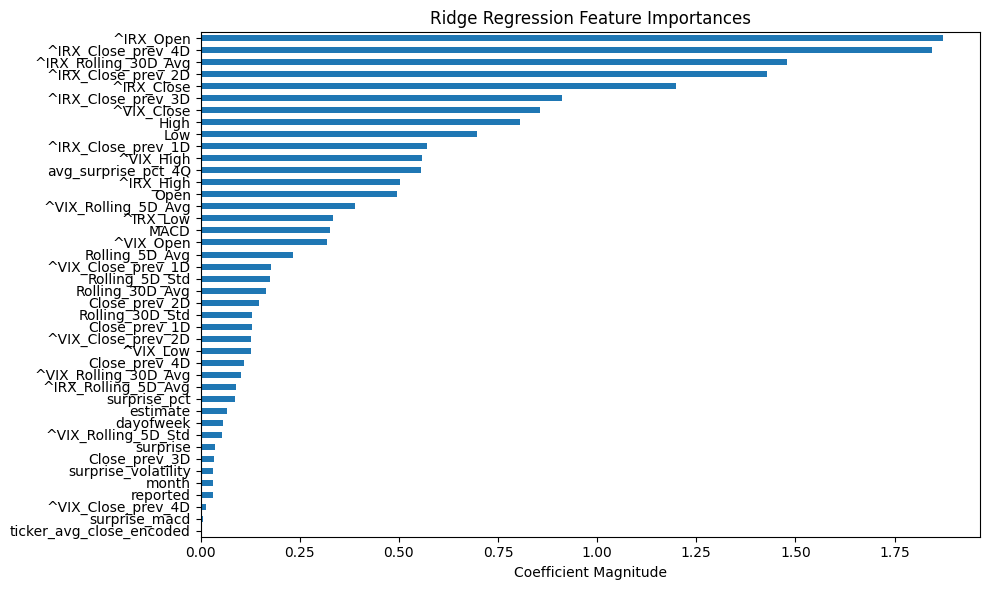

In [ ]:
print("Feature Importances (Ridge Coefficients):")
print(feature_importance)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title("Ridge Regression Feature Importances")
plt.xlabel("Coefficient Magnitude")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 984it [00:17, 32.78it/s]                         


Mean Absolute SHAP Values (Global Feature Importance):
High                        52.624944
Low                         50.279874
Open                        26.276348
Close_prev_1D               16.020930
Rolling_30D_Avg              7.853434
^VIX_Close                   4.161465
Close_prev_2D                3.984149
^VIX_Rolling_5D_Avg          3.822904
Close_prev_4D                3.604835
^VIX_Open                    3.358329
Rolling_5D_Avg               3.189545
^IRX_Rolling_30D_Avg         2.948235
^VIX_Low                     2.781834
^VIX_Close_prev_1D           2.347397
^IRX_Open                    2.138835
^VIX_High                    1.598609
^VIX_Close_prev_2D           1.585909
^IRX_Close_prev_2D           1.528252
Close_prev_3D                1.458295
Rolling_30D_Std              1.457501
^IRX_Close_prev_1D           1.176845
^IRX_Close_prev_4D           1.034411
ticker_avg_close_encoded     1.003546
^IRX_Low                     0.912950
Rolling_5D_Std               0.78

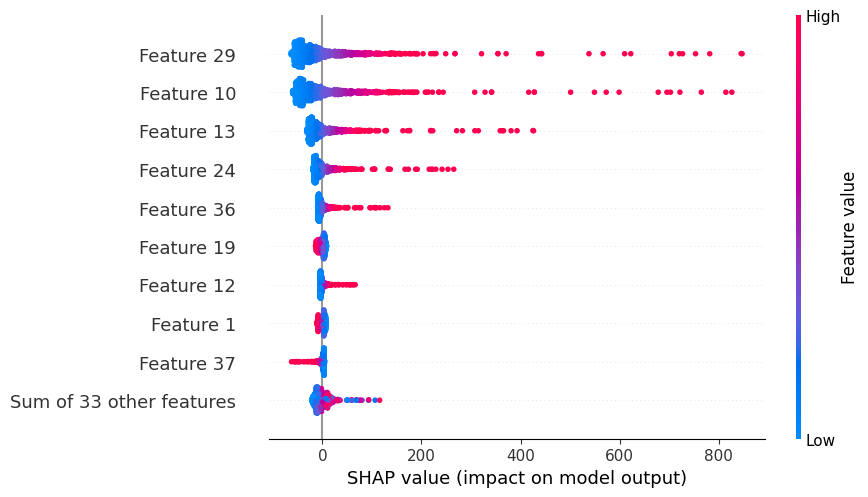

In [ ]:
import shap

explainer = shap.Explainer(ridge_model.predict, X_train_scaled)
shap_values = explainer(X_train_scaled)
shap_df = pd.DataFrame(shap_values.values, columns=important_features)

mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

print("Mean Absolute SHAP Values (Global Feature Importance):")
print(mean_abs_shap)

shap.plots.beeswarm(shap_values, max_display=10)

In [ ]:
df_test.columns

Index(['ticker', 'period_end_date', 'reported', 'estimate', 'surprise',
       'surprise_pct', 'avg_surprise_pct_4Q', 'std_surprise_pct_4Q',
       'pos_surprise_count_4Q', 'earning_release_date',
       ...
       '^IRX_Close_prev_4D', '^IRX_Volume_prev_4D', '^IRX_Rolling_5D_Avg',
       '^IRX_Rolling_5D_Std', '^IRX_Rolling_30D_Avg', '^IRX_Rolling_30D_Std',
       '^IRX_Momentum_5D', '^IRX_MACD', 'ticker_avg_close_encoded',
       'y_pred_close'],
      dtype='object', length=105)

In [ ]:
df_test, df_train = run_models(df, is_train=True)
from sklearn.linear_model import Ridge
model_ridge = LinearRegression()
model_ridge.fit(df_train[important_features], df_train['Close'])

df_train['y_pred_close'] = model_ridge.predict(df_train[important_features])
df_test['y_pred_close'] = model_ridge.predict(df_test[important_features])

mse_all = mean_squared_error(df_test['Close'], df_test['y_pred_all'])
mse_no_earnings = mean_squared_error(df_test['Close'], df_test['y_pred_no_earnings'])
mse_ridge = mean_squared_error(df_test['Close'], df_test['y_pred_close'])

print(f"Test MSE (All Features): {mse_all:.4f}")
print(f"Test MSE (No Earnings): {mse_no_earnings:.4f}")
print(f"Test MSE (Causal Inference): {mse_ridge:.4f}")


Test MSE (All Features): 24945.0295
Test MSE (No Earnings): 22998.8026
Test MSE (Causal Inference): 22.7360


MSE for TTWO (All Features): 16.4299
MSE for TTWO (No Earnings): 8.4579
MSE for TTWO (Causal Inference): 0.5871


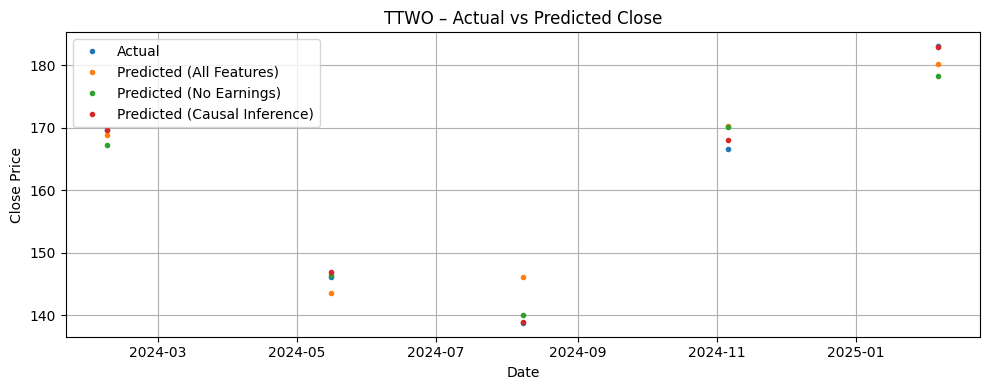

MSE for AZN (All Features): 13.7088
MSE for AZN (No Earnings): 15.4646
MSE for AZN (Causal Inference): 0.5585


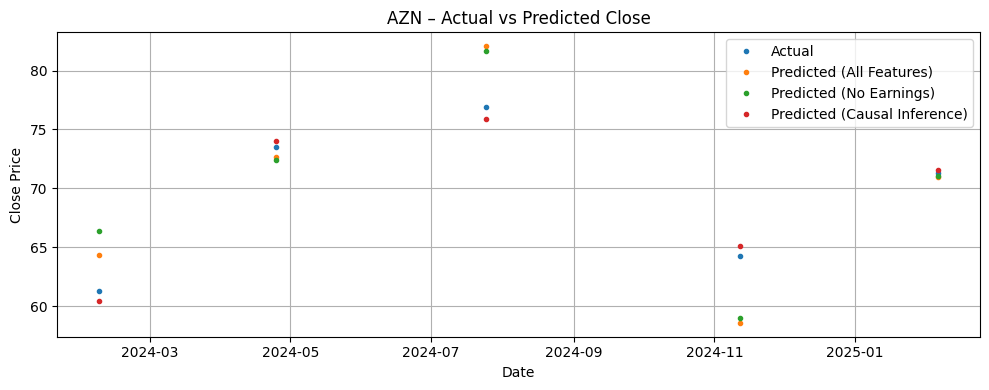

MSE for EXC (All Features): 3.6109
MSE for EXC (No Earnings): 2.7911
MSE for EXC (Causal Inference): 0.9697


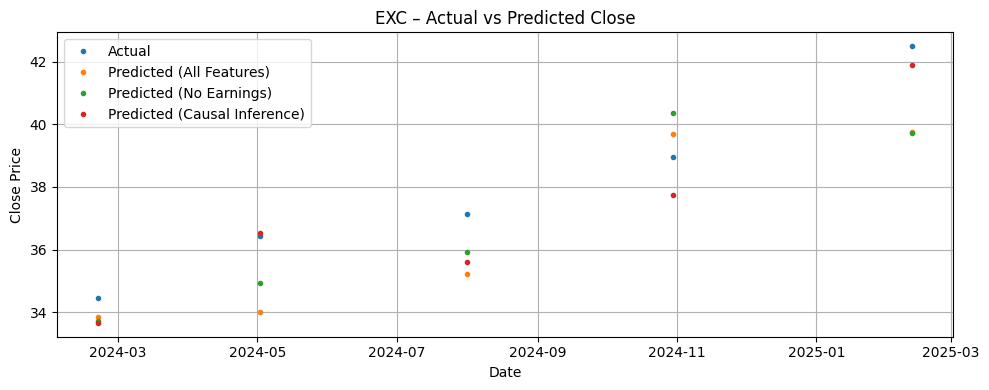

In [ ]:
sample_tickers = ['TTWO', 'AZN', 'EXC']

for ticker in sample_tickers:
    group = df_test[df_test['ticker'] == ticker]

    mse_causal = mean_squared_error(group['Close'], group['y_pred_close'])
    mse_all = mean_squared_error(group['Close'], group['y_pred_all'])
    mse_no_earnings = mean_squared_error(group['Close'], group['y_pred_no_earnings'])
    print(f'MSE for {ticker} (All Features): {mse_all:.4f}')
    print(f'MSE for {ticker} (No Earnings): {mse_no_earnings:.4f}')
    print(f'MSE for {ticker} (Causal Inference): {mse_causal:.4f}')

    plt.figure(figsize=(10, 4))
    plt.plot(group['date'], group['Close'], '.', label='Actual')
    plt.plot(group['date'], group['y_pred_all'], '.', label='Predicted (All Features)')
    plt.plot(group['date'], group['y_pred_no_earnings'], '.', label='Predicted (No Earnings)')
    plt.plot(group['date'], group['y_pred_close'], '.', label='Predicted (Causal Inference)')

    plt.title(f'{ticker} – Actual vs Predicted Close')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import time
import tracemalloc
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def benchmark_model(model, X_train, y_train, X_test, y_test, label=''):
    results = {'model': label}

    start_time = time.time()
    tracemalloc.start()

    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    current, peak = tracemalloc.get_traced_memory()
    end_time = time.time()

    tracemalloc.stop()

    results.update({
        'train_mse': mean_squared_error(y_train, train_pred),
        'test_mse': mean_squared_error(y_test, test_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'runtime_sec': end_time - start_time,
        'peak_memory_MB': peak / 10**6
    })

    return results

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor

df_train, df_test, X_train_all, X_train_no_earnings, y_train, X_test_all, X_test_no_earnings, y_test = data_setup(df)

results = []

results.append(
    benchmark_model(LinearRegression(), X_train_all, y_train, X_test_all, y_test, label="Linear (All)")
)

results.append(
    benchmark_model(LinearRegression(), X_train_no_earnings, y_train, X_test_no_earnings, y_test, label="Linear (No Earnings)")
)

results.append(
    benchmark_model(XGBRegressor(n_estimators=200, max_depth=5, random_state=42), X_train_all, y_train, X_test_all, y_test, label="XGB (All)")
)

results.append(
    benchmark_model(XGBRegressor(n_estimators=200, max_depth=5, random_state=42), X_train_no_earnings, y_train, X_test_no_earnings, y_test, label="XGB (No Earnings)")
)

df_train_causal, df_test_causal, X_train_causal, y_train_causal, X_test_causal, y_test_causal = data_setup_causal_timesplit(df, important_features)
results.append(
    benchmark_model(Ridge(alpha=1.0), X_train_causal, y_train_causal, X_test_causal, y_test_causal, label="Ridge (Causal)")
)

results.append(
    benchmark_model(XGBRegressor(n_estimators=200, max_depth=5, random_state=42),
                    X_train_causal, y_train_causal, X_test_causal, y_test_causal,
                    label="XGB (Causal)")
)

X_train_scaled = scale_features_with_weights(X_train_causal, feature_weights)
X_test_scaled = scale_features_with_weights(X_test_causal, feature_weights)
results.append(
    benchmark_model(XGBRegressor(n_estimators=200, max_depth=5, random_state=42), X_train_scaled, y_train_causal, X_test_scaled, y_test_causal, label="XGB (Causal+Weighted)")
)


In [ ]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="test_mse"))

                   model  train_mse      test_mse  train_r2   test_r2  \
4         Ridge (Causal)  11.824555     23.293959  0.999868  0.999901   
0           Linear (All)  89.388665    324.372090  0.999005  0.998615   
1   Linear (No Earnings)  92.189187    332.567748  0.998974  0.998580   
3      XGB (No Earnings)   0.010059  22998.802601  1.000000  0.901816   
2              XGB (All)   0.003765  24945.029540  1.000000  0.893507   
5           XGB (Causal)   0.002483  26153.697592  1.000000  0.888347   
6  XGB (Causal+Weighted)   0.002483  26153.697592  1.000000  0.888347   

   runtime_sec  peak_memory_MB  
4     0.093853        0.410352  
0     0.037184        0.472207  
1     0.077768        0.356802  
3     3.486312        0.527678  
2    12.398556        0.609620  
5     2.898506        0.567937  
6     1.458141        0.573528  
